This is for importing all the important libraries required for the script.

In [79]:
import cv2
import numpy as np
import os
import shutil
import matplotlib.pyplot as plt
from PIL import Image

import the data, if data is a video, extract frames into temp_frames folder

In [ ]:
# dataset_path = "videos_of_wildfires/Dramatic_evacuations_by_sea_as_forest_fires_rage_in_Italy_and_Turkey.mp4"
dataset_path = "FLAME 3 CV Dataset (Sycan Marsh)/Fire/Thermal"

if os.path.exists("temp_frames"):
        shutil.rmtree("temp_frames")

if dataset_path.endswith((".mp4", ".avi", ".mov")):
    os.makedirs("temp_frames")
    cap = cv2.VideoCapture(dataset_path)
    fps = cap.get(cv2.CAP_PROP_FPS)
    frame_count = 0
    while True:
        ret, frame = cap.read()
        if not ret:
            break 

        frame_filename = os.path.join("temp_frames", f"frame_{frame_count:04d}.jpg")
        cv2.imwrite(frame_filename, frame)
        frame_count += 1
    cap.release()
    image_folder="temp_frames"  
    frame_based=False
else:
    image_folder = dataset_path 
    fps=3
    frame_based=True

label_folder = os.path.join(dataset_path, "labels")

In [ ]:
filenames = sorted(os.listdir(image_folder))
# read the first image for video object
img = cv2.imread(os.path.join(image_folder, filenames[0]))
height, width = img.shape[:2]  
# initialise video object
fourcc = cv2.VideoWriter_fourcc(*'mp4v')  
out = cv2.VideoWriter("fire_detection.mp4", fourcc, fps, (width, height))
# detection counter
detected = 0
prev_frame = None

for filename in filenames:
    img_path = os.path.join(image_folder, filename)
    original = cv2.imread(img_path)
    img=original.copy()
    if frame_based:
        # create a mask from reference
        hsv = cv2.cvtColor(img, cv2.COLOR_RGB2HSV)
        S, V = hsv[:, :, 1], hsv[:, :, 2]
        # Define a smoke mask 
        smoke_mask = (S < 50) & (V > 120)
        # Remove smoke pixels
        img[smoke_mask] = [0, 0, 0]      
        # apply RGB thresholds
        R,G,B=img[:,:,0],img[:,:,1],img[:,:,2]
        R_mask = (R >= 80) & (R <= 255) # was 150,255
        G_mask = (G >= 50) & (G <= 255)   
        B_mask = (B >= 100)   & (B <= 225) # was 1,150
        brightness=(R+G+B)/3
        # combine and convert to binary mask
        RGB_mask = (R_mask & (G_mask | B_mask))
        # mask off original for cielab
        img[~RGB_mask] = [0, 0, 0]
    # convert the mask to CIELAB colorspace
    mask = cv2.cvtColor(img, cv2.COLOR_RGB2LAB)
    # split new mask into CIELAB channels
    L,A,B=mask[:,:,0],mask[:,:,1],mask[:,:,2]
    # apply thresholding
    L_mask = (L >= 40) & (L <= 255) # was 100,255
    A_mask = (A >= 0) & (A <= 160) # was 0,128
    B_mask = (B >= 0) & (B <= 140)
    # combine the channels to form a mask
    fire_mask=L_mask & A_mask & B_mask 
    # binarise the mask
    fire_mask=fire_mask.astype(np.uint8)*255
    # perform morphological operations
    kernel = np.ones((3, 3), np.uint8)
    fire_mask=cv2.morphologyEx(fire_mask, cv2.MORPH_OPEN, kernel)
    fire_mask = cv2.morphologyEx(fire_mask, cv2.MORPH_CLOSE, kernel)
    # find contours for bounding box
    contours, _ = cv2.findContours(fire_mask, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    for contour in contours:
        if cv2.contourArea(contour) > 100:  
            x, y, w, h = cv2.boundingRect(contour)
            aspect_ratio = float(w) / h
            if 0.3 < aspect_ratio < 3:  
                cv2.rectangle(original, (x, y), (x + w, y + h), (255, 255, 0), 2)
                detected += 1
    # write the image into the video object
    out.write(original)  
     
# release video object
out.release()
# remove extraction path
if os.path.exists("temp_frames"):
    shutil.rmtree("temp_frames")
# print the number of detected fire areas
print(f"Total detected fire areas: {detected}")


Total detected fire areas: 122


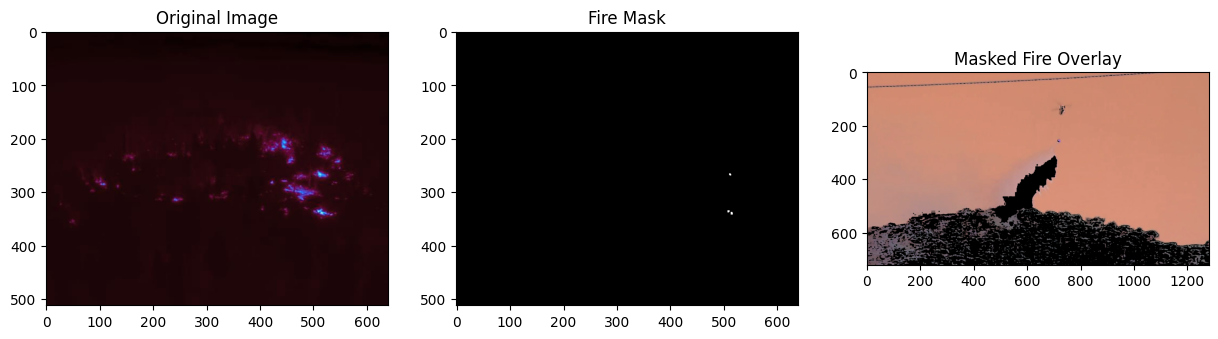

In [82]:
# some plots for visualisation
plt.figure(figsize=(15, 5))

plt.subplot(1, 3, 1)
plt.imshow(original)
plt.title("Original Image")

plt.subplot(1, 3, 2)
plt.imshow(fire_mask, cmap="gray")
plt.title("Fire Mask")

plt.subplot(1, 3, 3)
plt.imshow(colored_fire)
plt.title("Masked Fire Overlay")

plt.show()

In [83]:
# if actual_labels_available:
#         valid_comparisons = [x for x in computed_labels if x[2] is not None]  
#         correct = sum(1 for _, c, a in valid_comparisons if c == a)
#         accuracy = correct / len(valid_comparisons) * 100 if valid_comparisons else 0
#         print(f'✅ Accuracy: {accuracy:.2f}%')
# else:
#     print("⚠ No labels found. Skipping accuracy evaluation.")
# remove extraction path
